In [5]:
import time
from matplotlib.colors import ListedColormap

import tyssue
from tyssue import History
from tyssue.io.hdf5 import save_datasets, load_datasets
from tyssue.dynamics import effectors, model_factory, model_factory_vessel, model_factory_cylinder
from tyssue.generation.hexagonal_grids import hexa_cylinder
from tyssue.generation.shapes import sheet_from_cell_centers
from tyssue.geometry.cylinder_geometry import CylinderGeometry, CylinderGeometryInit
from tyssue import config
from tyssue.draw import sheet_view, create_gif
from tyssue.geometry.vessel_geometry import VesselGeometry as geom
from tyssue.solvers.viscous import EulerSolver
from tyssue.draw.ipv_draw import browse_history
from tyssue.topology.sheet_topology import cell_division, drop_face, split_vert
from tyssue.topology.base_topology import remove_face
from tyssue.behaviors import EventManager
from tyssue.generation.modifiers import create_anchors
try:
    from ..behaviors.behaviors import *
except:
    print("Failed relative import, attempting direct import")
    from vivarium_tyssue.behaviors import *
import ipyvolume as ipv

from process_bigraph import Process, Composite, ProcessTypes
from process_bigraph.emitter import emitter_from_wires, gather_emitter_results

%load_ext snakeviz

/Users/tasnifrahman/PycharmProjects/vivatyssue/src/tyssue/dynamics/effectors.py:539: SyntaxWarning: invalid escape sequence '\m'
  ..math: \frac{K_Y}{2}(A_{\mathrm{lumen}} - A_{0,\mathrm{lumen}})^2


collision solver could not be imported You may need to install CGAL and re-install tyssue
Failed relative import, attempting direct import


NameError: name 'BoundaryElasticity' is not defined

In [2]:
# def fix_points_cylinder(sheet, radius):
#     xy = sheet.vert_df[['x', 'y']].to_numpy()
#     r = np.linalg.norm(xy, axis=1)
#     r_safe = np.where(r == 0, 1e-12, r)
#     xy_on_cylinder = (radius/r_safe)[:, None] * xy
#     sheet.vert_df['x'] = xy_on_cylinder[:, 0]
#     sheet.vert_df['y'] = xy_on_cylinder[:, 1]

In [3]:
# def divide_cylinder(sheet, manager, geom, division_rate, dt, radius):
#     update_stem_cells(sheet)
#     stem_cells = sheet.face_df.loc[(sheet.face_df["stem_cell"] == 1) & (sheet.face_df["area"]>=0.7*sheet.face_df["area"].mean())].copy()
#     n_stem = len(stem_cells)
#     cell_ids = list(stem_cells["unique_id"])
#     n_divisions = np.random.binomial(n=n_stem, p=division_rate * dt)
#     dividing_cells = np.random.choice(cell_ids, size=n_divisions, replace=False)
#
#     for cell_id in dividing_cells:
#         cell_idx = int(sheet.face_df[sheet.face_df["unique_id"] == cell_id].index[0])
#         daughter = cell_division(sheet, cell_idx, geom)
#     manager.append(divide_cylinder, geom=geom, division_rate=division_rate, dt=dt, radius=radius)
#     fix_points_cylinder(sheet, radius=radius)

In [4]:
# def apoptosis_cylinder(sheet, manager, death_rate, dt, radius, geom):
#     update_stem_cells(sheet)
#     dying_cells = sheet.face_df.loc[sheet.face_df["dying_cell"] == 1]
#     n_dying = len(dying_cells)
#     cell_ids = list(dying_cells["unique_id"])
#     n_deaths = np.random.binomial(n=n_dying, p=death_rate * dt)
#     to_kill = np.random.choice(cell_ids, size=n_deaths, replace=False)
#
#     for cell_id in to_kill:
#         cell_idx = int(sheet.face_df[sheet.face_df["unique_id"] == cell_id].index[0])
#         # if sheet.face_df.loc[cell_idx, "boundary"] == 0:
#         vertex = remove_face(sheet, cell_idx)
#         # else:
#         #     vertex = drop_face(sheet, cell_idx, geom)
#         # split_vert(sheet, vertex)
#     manager.append(apoptosis_cylinder, death_rate=death_rate, dt=dt, radius=radius, geom=geom)
#     fix_points_cylinder(sheet, radius=radius)

In [5]:
def auto_correlated_tension(sheet, manager, sigma, phi):
    """
    Parameters:
    sheet: tyssue.Sheet object
    manager: EventManager object
    sigma: float, standard deviation
    phi: float, autocorrelation factor between 0 and 1 (AR(1) autocorrelation factor)
        closer to 1 means stronger correlation
    Returns:
    updates sheet.edge_df["line_tension"]
    """
    noise = np.random.normal(loc=0, scale=sigma, size=len(sheet.edge_df["line_tension"]))
    sheet.edge_df["line_tension"] =  phi * sheet.edge_df["line_tension"] + noise
    manager.append(auto_correlated_tension, sigma=sigma, phi=phi)

In [6]:
# def update_stem_cells(eptm):
#     eptm.face_df['stem_cell'] = 0
#     eptm.face_df['dying_cell'] = 0
#     eptm.face_df.loc[(eptm.face_df["boundary"] != 1) & (eptm.face_df["z"] < 0), "stem_cell"] = 1
#     eptm.face_df.loc[(eptm.face_df["z"] > 0), "dying_cell"] = 1

In [7]:
radius = 2.576
#generate cylindrical tissue
points_xyz = hexa_cylinder(16,30, radius = radius, noise = 0.0, capped = True)
sheet = sheet_from_cell_centers(points_xyz)
sheet = sheet.extract_bounding_box(z_boundary = (-10.1, 30), coords=['x', 'y', 'z'])
sheet.sanitize(trim_borders=False)
create_anchors(sheet)
sheet = sheet.extract_bounding_box(z_boundary = (-10.1, 10), coords=['x', 'y', 'z'])
sheet.sanitize(trim_borders=False)
geom.update_all(sheet)
sheet.network_changed = False

/Users/tasnifrahman/PycharmProjects/vivatyssue/src/tyssue/generation/modifiers.py:193: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet.edge_df = pd.concat([sheet.edge_df, anchor_edge_df], sort=True)


In [8]:
# save_datasets("test_cylinder.hf5", sheet)

In [9]:
sheet.face_df.loc[(sheet.face_df["z"]<8) & (sheet.face_df["z"]>-8), "area"].mean()

np.float64(1.0001577509936472)

In [10]:
colors = ["green", "coral", "pink", "yellow", "purple"]
cmap = ListedColormap(colors)
sheet.face_df["color"] = 0
sheet.face_df.loc[(sheet.face_df["z"]<-5), "color"] = 1
sheet.face_df.loc[(sheet.face_df["z"]>-5) & (sheet.face_df["z"]<0), "color"] = 2
goblet_fraction = 0.2
enterocyte_fraction = 0.15
gob_to_replace = int(len(sheet.face_df) * goblet_fraction)
gob_indices = np.random.choice(sheet.face_df.loc[(sheet.face_df["z"]>0)].index, size=gob_to_replace)
sheet.face_df.loc[gob_indices, "color"] = 3

ent_to_replace = int(len(sheet.face_df) * enterocyte_fraction)
ent_indices = np.random.choice(sheet.face_df.loc[(sheet.face_df["z"]>0) & (sheet.face_df["color"] != 3)].index, size=ent_to_replace)
sheet.face_df.loc[ent_indices, "color"] = 4

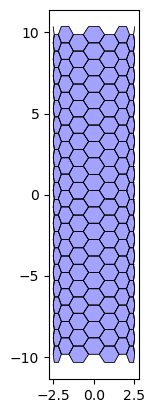

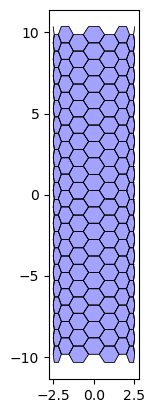

In [15]:
draw_specs = tyssue.config.draw.sheet_spec()
draw_specs["face"]["visible"] = True
draw_specs["face"]["visible"] = True
draw_specs["face"]["alpha"] = 0.2
draw_specs["face"]["color"] = "blue"
draw_specs["edge"]["color"] = "black"

fig, ax = sheet_view(sheet, coords=['x', 'z'], mode="2D", dpi=300, **draw_specs)
fig

In [12]:
#generate model
model = model_factory_vessel([
    effectors.LineTension,
    effectors.FaceAreaElasticity,
    effectors.PerimeterElasticity,
], effectors.FaceAreaElasticity)

In [13]:
#set model parameters
sheet.face_df["area_elasticity"] = 1
sheet.face_df["prefered_area"] = 1
sheet.face_df["perimeter_elasticity"] = 1
sheet.face_df["prefered_perimeter"] = 3.5
sheet.edge_df["line_tension"] = np.random.normal(loc=0, scale=0.01, size=len(sheet.edge_df))
sheet.edge_df["is_active"] = 1
sheet.vert_df["viscosity"] = 5
sheet.vert_df["prefered_deviation"] = 0
sheet.vert_df["surface_elasticity"] = 5
sheet.settings["threshold_length"] = 0.1
geom.update_all(sheet)

In [14]:
sheet.edge_df["face"]

edge
0       123
1       123
2       123
3       123
4       123
       ... 
1915    284
1916    284
1917    284
1918    284
1919     68
Name: face, Length: 1920, dtype: int64

In [15]:
history = History(sheet)

In [16]:
#set time-step
dt=0.1

In [17]:
#initialize manager and add division and apoptosis
#set division and apoptosis parameters
manager = EventManager()
manager.append(divide_cylinder, geom=geom, division_rate=0.0005, dt=dt, radius=radius)
manager.append(apoptosis_cylinder, death_rate=0.0005, dt=dt, radius=radius, geom=geom)
manager.append(auto_correlated_tension, sigma = 0.01, phi=0.5)

In [18]:
#initialize solver
solver = EulerSolver(
    sheet,
    geom,
    model,
    history=history,
    auto_reconnect=True,
    manager=manager,
)

In [19]:
sheet.edge_df["is_active"]

edge
0       1
1       1
2       1
3       1
4       1
       ..
1915    1
1916    1
1917    1
1918    1
1919    1
Name: is_active, Length: 1920, dtype: int64

In [20]:
#set time variables
dt = dt
tf = 300
sheet.settings["dt"] = dt
sheet.settings["p_4"] = 1/(dt)
sheet.settings["p_5p"] = 1/(dt)
#run simulation
start = time.time()
res = solver.solve(tf=tf, dt = dt)
print(f"Time Elapsed: {time.time()-start}")

Time Elapsed: 84.18165802955627


In [21]:
sheet.edge_df

,at_border,boundary,cell,cell_o,cx,cy,cz,dx,dy,dz,...,trgt,trgt_o,tx,ty,tz,unique_id,unique_id_max,ux,uy,uz
edge,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0.0,0.0,0.0,-0.215825,-0.147281,0.420867,...,214,410,-1.558054,2.051400,5.091186,0,6120,-0.435711,-0.297332,0.849653
1,0,0,0,0,0.0,0.0,0.0,-0.735950,-0.304957,-0.002332,...,171,339,-1.342229,2.198681,4.670318,2,6120,-0.924107,-0.382924,-0.002929
2,0,0,0,0,0.0,0.0,0.0,-0.307078,-0.054927,-0.535432,...,168,336,-0.606279,2.503638,4.672651,4,6120,-0.495578,-0.088645,-0.864110
3,0,0,0,0,0.0,0.0,0.0,0.226362,0.036748,-0.371823,...,170,338,-0.299202,2.558565,5.208083,6,6120,0.518196,0.084126,-0.851190
4,0,0,0,0,0.0,0.0,0.0,0.824828,0.328139,0.025125,...,169,337,-0.525564,2.521817,5.579906,8,6120,0.928981,0.369574,0.028297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1894,0,0,0,0,0.0,0.0,0.0,0.021628,-0.011439,-0.114146,...,659,663,1.215141,2.271389,7.304019,1807,6120,0.185267,-0.097985,-0.977798
1895,0,0,0,0,0.0,0.0,0.0,0.127065,0.009896,-0.062702,...,660,164,-0.136415,2.572385,7.878285,1415,6120,0.894737,0.069680,-0.441518
1896,0,0,0,0,0.0,0.0,0.0,-0.127065,-0.009896,0.062702,...,369,861,-0.263480,2.562490,7.940987,1510,6120,-0.894737,-0.069680,0.441518


In [20]:
ipv.clear()

In [30]:
ipv.clear()
browse_history(history,**draw_specs)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

interactive(children=(IntSlider(value=0, description='i', max=20000), Output()), _dom_classes=('widget-interac…

In [22]:
len(sheet.face_df)

289

In [23]:
sheet.edge_df["is_active"]

edge
0       1
1       1
2       1
3       1
4       1
       ..
1705    1
1706    1
1707    1
1708    1
1709    1
Name: is_active, Length: 1710, dtype: int64

In [31]:
ipv.clear()
fig, mesh = sheet_view(sheet, coords=['x', 'y', 'z'], mode="3D", **draw_specs)
ipv.pylab.xyzlabel("x-axis", "y-axis", "z-axis")
ipv.pylab.style.axes_on()
fig

Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.0, position=(0.0,…

In [25]:
sheet1 = history.retrieve(0.0)

In [26]:
sheet.face_df

,at_border,boundary,cell,cell_o,cx,cy,cz,dx,dy,dz,...,trgt,trgt_o,tx,ty,tz,unique_id,unique_id_max,ux,uy,uz
edge,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0.0,0.0,0.0,0.032651,0.161414,-0.191746,...,128,842,-2.507246,0.591181,-5.145116,12,6120,0.129179,0.638606,-0.758610
1,0,0,0,0,0.0,0.0,0.0,-0.215514,0.675582,0.411121,...,491,841,-2.538551,-0.437646,-6.583725,14,6120,-0.262900,0.824123,0.501515
2,0,0,0,0,0.0,0.0,0.0,0.013198,-0.577271,-0.177762,...,211,843,-2.552502,-0.347144,-6.125888,20,6120,0.021844,-0.955436,-0.294212
3,0,0,0,0,0.0,0.0,0.0,0.785330,0.333331,-0.338864,...,253,593,1.385236,-2.171842,9.336233,21,6120,0.855597,0.363155,-0.369184
4,0,0,0,0,0.0,0.0,0.0,0.027642,0.006458,-0.571208,...,65,591,0.599906,-2.505172,9.675097,46,6120,0.048332,0.011293,-0.998768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1705,0,0,0,0,0.0,0.0,0.0,0.169586,-0.103709,-0.076343,...,597,575,-1.258147,-2.247853,-6.709700,234,6120,0.792337,-0.484545,-0.356690
1706,0,0,0,0,0.0,0.0,0.0,0.374195,-0.171838,0.393733,...,554,730,-0.884482,-2.419394,-7.173537,685,6120,0.657683,-0.302022,0.692022
1707,0,0,0,0,0.0,0.0,0.0,-0.374195,0.171838,-0.393733,...,598,730,-1.258678,-2.247556,-7.567270,685,6120,-0.657683,0.302022,-0.692022


In [32]:
ipv.clear()
browse_history(history, **draw_specs)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

interactive(children=(IntSlider(value=0, description='i', max=20000), Output()), _dom_classes=('widget-interac…

In [39]:
sheet.edge_df.to_dict()

{'at_border': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0,
  14: 0,
  15: 0,
  16: 0,
  17: 0,
  18: 0,
  19: 0,
  20: 0,
  21: 0,
  22: 0,
  23: 0,
  24: 0,
  25: 0,
  26: 0,
  27: 0,
  28: 0,
  29: 0,
  30: 0,
  31: 0,
  32: 0,
  33: 0,
  34: 0,
  35: 0,
  36: 0,
  37: 0,
  38: 0,
  39: 0,
  40: 0,
  41: 0,
  42: 0,
  43: 0,
  44: 0,
  45: 0,
  46: 0,
  47: 0,
  48: 0,
  49: 0,
  50: 0,
  51: 0,
  52: 0,
  53: 0,
  54: 0,
  55: 0,
  56: 0,
  57: 0,
  58: 0,
  59: 0,
  60: 0,
  61: 0,
  62: 0,
  63: 0,
  64: 0,
  65: 0,
  66: 0,
  67: 0,
  68: 0,
  69: 0,
  70: 0,
  71: 0,
  72: 0,
  73: 0,
  74: 0,
  75: 0,
  76: 0,
  77: 0,
  78: 0,
  79: 0,
  80: 0,
  81: 0,
  82: 0,
  83: 0,
  84: 0,
  85: 0,
  86: 0,
  87: 0,
  88: 0,
  89: 0,
  90: 0,
  91: 0,
  92: 0,
  93: 0,
  94: 0,
  95: 0,
  96: 0,
  97: 0,
  98: 0,
  99: 0,
  100: 0,
  101: 0,
  102: 0,
  103: 0,
  104: 0,
  105: 0,
  106: 0,
  107: 0,
  108: 0,
  109: 

In [37]:
sheet.face_df.to_dict(orient="records")

[{'x': -2.4900716712661546,
  'y': 4.727754810344524e-06,
  'z': 0.7575652102387761,
  'num_sides': 6,
  'area': 1.0002121381737608,
  'perimeter': 3.739236169611521,
  'is_alive': 1,
  'id': 0,
  'unique_id': 0,
  'unique_id_max': 1024,
  'face_o': 3,
  'opposite': -1,
  'vol': 0.0,
  'phi': -3.141592653589793,
  'rho': 0.500915619307095,
  'theta': 0.05071678481150169,
  'at_border': 0,
  'boundary': 0},
 {'x': -2.3011517315546537,
  'y': 0.9531816077874904,
  'z': 0.2525184271260058,
  'num_sides': 6,
  'area': 1.001059991206965,
  'perimeter': 3.74075707409507,
  'is_alive': 1,
  'id': 0,
  'unique_id': 1,
  'unique_id_max': 1024,
  'face_o': 4,
  'opposite': -1,
  'vol': 0.0,
  'phi': 2.748893571891069,
  'rho': 0.5004987799343317,
  'theta': 0.016918424135221887,
  'at_border': 0,
  'boundary': 0},
 {'x': -2.2997823895361384,
  'y': 0.9526065348103027,
  'z': 1.2623051164859396,
  'num_sides': 6,
  'area': 0.9991656891172069,
  'perimeter': 3.7373623757349317,
  'is_alive': 1,
  

#### Generate A Flat Rectangular Tissue

In [17]:
from tyssue.generation.hexagonal_grids import hexa_grid2d, hexa_grid3d
from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue import Sheet

In [34]:
sheet = Sheet.planar_sheet_3d(
    'basic2D', # a name or identifier for this sheet
    nx=17, # approximate number of cells on the x axis
    ny=15, # approximate number of cells along the y axis
    distx=1.076, # distance between 2 cells along x
    disty=1.076 # distance between 2 cells along y
)
sheet.sanitize(trim_borders=True)
geom.update_all(sheet)

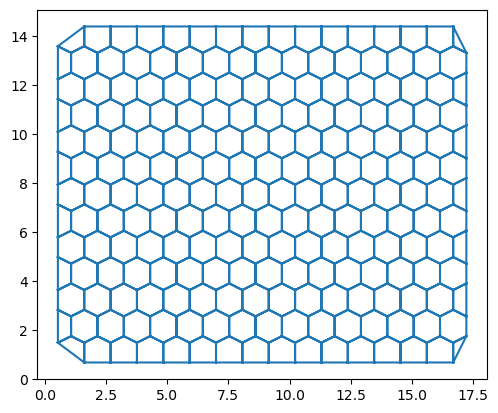

In [35]:
fig, ax = sheet_view(sheet, coords=['x', 'y'], mode="quick")

In [36]:
sheet.face_df["area"].mean()

np.float64(1.0930685673076925)

In [37]:
save_datasets("test_square.hf5", sheet)